In [ ]:
import pandas as pd
import time
from datetime import datetime
from openai import OpenAI
from tqdm import tqdm
import re
import tiktoken

# --- Configuration ---
LITELLM_PROXY_URL = ""
LITELLM_PROXY_API_KEY = "sk-S4vI4ayBQ6oPE-WSRBBn_g"

client = OpenAI(
    api_key=LITELLM_PROXY_API_KEY,
    base_url=LITELLM_PROXY_URL
)

OPENAI_MODEL = "GPT-4o"

# =====================================================================================================
# --- CONFIGURE FOR EACH NEW DATASET ---
# =====================================================================================================
# Change INPUT_FILE_NAME and the column mappings depending on the dataset.

# Example: For infoevents3.csv
# INPUT_FILE_NAME = "infoevents3.csv"
# ACTUAL_DESCRIPTION_COLUMN_IN_FILE = "applicationandtechnologytext"
# ACTUAL_SYNOPSIS_COLUMN_IN_FILE = "dealsynopsistext"
# ACTUAL_DATE_COLUMN_IN_FILE = None

# Example: For infoevents2.csv
INPUT_FILE_NAME = "infoevents2.csv"
ACTUAL_DESCRIPTION_COLUMN_IN_FILE = "descriptionshort"
ACTUAL_SYNOPSIS_COLUMN_IN_FILE = None
ACTUAL_DATE_COLUMN_IN_FILE = "funddate"

# =====================================================================================================

# --- Load Dataset ---
df = pd.read_csv(INPUT_FILE_NAME)

# Add result columns
df["category"] = ""
df["explanation"] = ""
df["confidence"] = ""
df["raw_output"] = ""

# Combine text fields
description_content = (
    df[ACTUAL_DESCRIPTION_COLUMN_IN_FILE].fillna("")
    if ACTUAL_DESCRIPTION_COLUMN_IN_FILE and ACTUAL_DESCRIPTION_COLUMN_IN_FILE in df.columns
    else ""
)
synopsis_content = (
    df[ACTUAL_SYNOPSIS_COLUMN_IN_FILE].fillna("")
    if ACTUAL_SYNOPSIS_COLUMN_IN_FILE and ACTUAL_SYNOPSIS_COLUMN_IN_FILE in df.columns
    else ""
)

df["combined_text"] = description_content + " " + synopsis_content

# Date handling
if ACTUAL_DATE_COLUMN_IN_FILE and ACTUAL_DATE_COLUMN_IN_FILE in df.columns:
    df["date_for_llm"] = pd.to_datetime(df[ACTUAL_DATE_COLUMN_IN_FILE], errors="coerce")
    df["deal_year"] = df["date_for_llm"].dt.year.fillna(df["date_for_llm"].dt.year.median())
else:
    print(f"⚠️ Date column '{ACTUAL_DATE_COLUMN_IN_FILE}' not found. Using default year.")
    df["deal_year"] = 2020

# --- Features ---
ev_keywords = [
    "electric", "battery", "lithium", "charging", "ev platform", "e-motor",
    "fuel cell", "hybrid electric", "plug-in hybrid", "bms",
    "battery management system", "inverter", "power electronics",
    "new energy vehicle", "electrification", "automobile batteries"
]
def has_ev_keywords(text):
    return any(re.search(r"\b" + keyword + r"\b", text, re.IGNORECASE) for keyword in ev_keywords)

propulsion_keywords = [
    "engine", "motor vehicle manufacturing", "powertrain", "drivetrain",
    "combustion", "diesel", "gasoline", "transmission", "ICEV", "automobiles",
    "trucks", "buses", "motorcycles", "vehicles", "internal combustion", "passenger cars"
]
accessory_service_keywords = [
    "dealership", "car rental", "logistics", "telematics", "electronic components",
    "software", "insurance", "real estate", "crm", "marketing", "fleet management"
]

def get_automotive_focus(text):
    text_lower = text.lower()
    is_propulsion = any(keyword in text_lower for keyword in propulsion_keywords)
    is_accessory_service = any(keyword in text_lower for keyword in accessory_service_keywords)
    if is_propulsion and not is_accessory_service:
        return "core propulsion or vehicle manufacturing"
    elif is_accessory_service and not is_propulsion:
        return "general automotive accessory or service (not core propulsion)"
    elif is_propulsion and is_accessory_service:
        return "mix of propulsion and accessory/service"
    else:
        return "general automotive or non-automotive"

df["has_ev_keywords"] = df["combined_text"].apply(has_ev_keywords)
df["automotive_focus"] = df["combined_text"].apply(get_automotive_focus)

# --- Category Definitions ---
CATEGORY_DEFINITIONS = {
    1: "ICEV Support: Deals related to ICE propulsion systems (engines, transmissions, combustion vehicles).",
    2: "EV Support: Deals related to EV propulsion systems (batteries, motors, charging, EV platforms).",
    3: "Neither: General automotive services/parts not directly tied to propulsion."
}

# --- Few-shot Examples (25 balanced) ---
example_block = """Example 1:
- Desc: Anhui Ankai Automobile Co Ltd manufactures and wholesales automobiles.
- Synop: JAC Group acquired a 28.12% stake.
EXPLANATION: This company manufactures automobiles without EV mention, making it ICEV Support.
CATEGORY: 1
CONFIDENCE: 95

Example 2:
- Desc: Manufacture motor vehicles
- Synop: Ford acquired Belgian motor vehicle manufacturer.
EXPLANATION: Direct manufacturing of combustion motor vehicles → ICEV Support.
CATEGORY: 1
CONFIDENCE: 95

Example 3:
- Desc: Cold-start injector systems for diesel engines
- Synop: OEM acquisition for combustion reliability in extreme weather.
EXPLANATION: Diesel engine injector systems directly support ICE propulsion.
CATEGORY: 1
CONFIDENCE: 95

Example 4:
- Desc: Parts logistics firm for ICE vehicle maintenance
- Synop: OEM acquired to streamline ICE supply chain.
EXPLANATION: Provides logistics services for ICE vehicles, supporting ICEV ecosystem.
CATEGORY: 1
CONFIDENCE: 95

Example 5:
- Desc: Data tool for ICE emission compliance
- Synop: Ensures combustion engine lines meet regulatory norms.
EXPLANATION: Regulatory compliance tools for ICE emissions → ICEV Support.
CATEGORY: 1
CONFIDENCE: 95

Example 6:
- Desc: Legacy ICE car manufacturer
- Synop: Acquisition to consolidate combustion vehicle production.
EXPLANATION: Legacy OEM focused on ICE production → ICEV Support.
CATEGORY: 1
CONFIDENCE: 95

Example 7:
- Desc: Lithium-ion battery supplier for EVs
- Synop: OEM secured supplier to support electrification.
EXPLANATION: Lithium-ion batteries are a core EV component → EV Support.
CATEGORY: 2
CONFIDENCE: 95

Example 8:
- Desc: EV chassis and frame producer
- Synop: Acquisition to scale lightweight EV platforms.
EXPLANATION: Supplies EV chassis/frames, critical for EV platforms.
CATEGORY: 2
CONFIDENCE: 95

Example 9:
- Desc: EV charging network API
- Synop: Used to manage station load balancing.
EXPLANATION: API for EV charging management → EV Support.
CATEGORY: 2
CONFIDENCE: 95

Example 10:
- Desc: Inverter and motor controller firm
- Synop: Powers electric powertrains in new vehicle line.
EXPLANATION: Inverters/controllers directly support EV propulsion.
CATEGORY: 2
CONFIDENCE: 95

Example 11:
- Desc: Battery module testing system
- Synop: Validates EV battery packs before installation.
EXPLANATION: Tests EV battery modules in assembly → EV Support.
CATEGORY: 2
CONFIDENCE: 95

Example 12:
- Desc: Smart grid energy optimizer
- Synop: Balances load during peak EV usage.
EXPLANATION: Optimizes grid load for EV charging → EV Support.
CATEGORY: 2
CONFIDENCE: 95

Example 13:
- Desc: EV fleet charging scheduler
- Synop: Coordinates charging for delivery vans.
EXPLANATION: Schedules EV fleet charging → EV Support.
CATEGORY: 2
CONFIDENCE: 95

Example 14:
- Desc: Retrofit kit provider
- Synop: OEM funds conversion of ICE fleets to EV.
EXPLANATION: Converts ICE fleets into EVs → EV Support.
CATEGORY: 2
CONFIDENCE: 95

Example 15:
- Desc: Electric utility vehicles
- Synop: Manufacturer acquired for electric tractors/trucks.
EXPLANATION: Explicit EV focus → EV Support.
CATEGORY: 2
CONFIDENCE: 95

Example 16:
- Desc: CRM platform for dealerships
- Synop: SaaS for sales analytics.
EXPLANATION: General dealership CRM not tied to propulsion → Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 17:
- Desc: Automotive ad-tech firm
- Synop: Helps OEMs run promotions.
EXPLANATION: Provides marketing solutions, unrelated to propulsion → Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 18:
- Desc: B2C car rental app
- Synop: Helps users compare and book cars.
EXPLANATION: Rental apps provide consumer services, not propulsion → Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 19:
- Desc: Logistics routing platform
- Synop: Focused on delivery optimization.
EXPLANATION: Provides logistics software, not propulsion → Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 20:
- Desc: Vehicle pricing insights API
- Synop: SaaS tool for dealerships.
EXPLANATION: Pricing insights not related to propulsion → Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 21:
- Desc: Electric utility company
- Synop: Acquisition of regional power provider.
EXPLANATION: Utility company, not vehicle propulsion → Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 22:
- Desc: Supplier of car seats and interiors
- Synop: OEM acquisition for interior design.
EXPLANATION: Interior parts unrelated to propulsion → Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 23:
- Desc: Service partner for general electronics
- Synop: OEM partners for non-propulsion electronics.
EXPLANATION: General electronics not tied to ICE/EV propulsion → Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 24:
- Desc: EV AI degradation prediction
- Synop: Predicts EV battery health.
EXPLANATION: EV-specific AI tool → EV Support.
CATEGORY: 2
CONFIDENCE: 95

Example 25:
- Desc: Smart charger app
- Synop: Manages home/fleet charging.
EXPLANATION: EV charger scheduling → EV Support.
CATEGORY: 2
CONFIDENCE: 95
"""

# --- Classification Function ---
def get_openai_classification(text_description, deal_synopsis, deal_year, has_ev_keywords_flag, automotive_focus_type, row_sdcdealno=None):
    system_message_content = (
        "You are an expert automotive investment consultant. "
        "Classify each deal as: 1 (ICEV Support), 2 (EV Support), or 3 (Neither).\n\n"
    )
    for cat_num, desc in CATEGORY_DEFINITIONS.items():
        system_message_content += f"Category {cat_num}: {desc}\n"
    system_message_content += "\nHere are diverse examples:\n\n"
    system_message_content += example_block + "\n--- End Examples ---\n\n"

    user_message_content = (
        f"Now classify this deal:\n"
        f"Description: '''{text_description}'''\n"
        f"Deal Synopsis: '''{deal_synopsis}'''\n"
        f"Date Announced: {int(deal_year)}\n"
        f"Analyzed features: EV Keywords: {'Yes' if has_ev_keywords_flag else 'No'}, Focus: {automotive_focus_type}\n\n"
        f"EXPLANATION:\nCATEGORY: [1/2/3/NA]\nCONFIDENCE: [1-100]\n"
    )

    try:
        response = client.chat.completions.create(
            model=OPENAI_MODEL,
            messages=[{"role": "system", "content": system_message_content}, {"role": "user", "content": user_message_content}],
            temperature=0,
            max_tokens=200
        )
        content = response.choices[0].message.content.strip() if response.choices else ""
        parsed_category, parsed_confidence, parsed_explanation = "NA", 0, ""
        if content:
            lines = content.splitlines()
            current_section = None
            for line in lines:
                line = line.strip()
                if line.upper().startswith("EXPLANATION:"):
                    current_section = "EXPLANATION"
                    parsed_explanation += line[len("EXPLANATION:"):].strip() + " "
                elif line.upper().startswith("CATEGORY:"):
                    value = line[len("CATEGORY:"):].strip()
                    if value.isdigit() and int(value) in {1, 2, 3}:
                        parsed_category = int(value)
                    elif value.upper() == "NA":
                        parsed_category = "NA"
                elif line.upper().startswith("CONFIDENCE:"):
                    value = line[len("CONFIDENCE:"):].strip()
                    if value.isdigit():
                        parsed_confidence = int(value)
                elif current_section == "EXPLANATION":
                    parsed_explanation += line + " "
            parsed_explanation = parsed_explanation.strip()
        return {"category": parsed_category, "confidence": parsed_confidence, "explanation": parsed_explanation, "raw_output": content}
    except Exception as e:
        return {"category": "error", "confidence": 0, "explanation": str(e), "raw_output": f"API Error: {e}"}

# --- Tokenizer Setup ---
try:
    enc = tiktoken.get_encoding("o200k_base") if OPENAI_MODEL.lower() in {"gpt-4o", "gpt-4o-mini"} else tiktoken.get_encoding("cl100k_base")
except KeyError:
    enc = tiktoken.get_encoding("cl100k_base")

# --- Main Loop ---
df["tokens_used"] = 0
for i, row in tqdm(df.iterrows(), total=len(df)):
    desc_val = row[ACTUAL_DESCRIPTION_COLUMN_IN_FILE] if ACTUAL_DESCRIPTION_COLUMN_IN_FILE in df.columns else ""
    syn_val = row[ACTUAL_SYNOPSIS_COLUMN_IN_FILE] if ACTUAL_SYNOPSIS_COLUMN_IN_FILE in df.columns else ""
    year_val = row["deal_year"]

    result = get_openai_classification(
        text_description=str(desc_val),
        deal_synopsis=str(syn_val),
        deal_year=year_val,
        has_ev_keywords_flag=row["has_ev_keywords"],
        automotive_focus_type=row["automotive_focus"],
        row_sdcdealno=row.get("sdcdealno", "N/A")
    )

    df.at[i, "category"] = result["category"]
    df.at[i, "confidence"] = result["confidence"]
    df.at[i, "explanation"] = result["explanation"]
    df.at[i, "raw_output"] = result["raw_output"]

    df.at[i, "tokens_used"] = len(enc.encode(str(desc_val) + " " + str(syn_val)))
    time.sleep(1.2)

# --- Save Results ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"{INPUT_FILE_NAME.replace('.csv','')}_with_predictions_{timestamp}.csv"
df.to_csv(filename, index=False)
print(f"✅ Saved predictions to {filename}")



100%|██████████| 2506/2506 [1:48:06<00:00,  2.59s/it]

✅ Saved predictions to infoevents2_with_predictions_20250930_175324.csv


Join key: deal_id (from investmentuuid)
Pred rows: 2506  | pred valid 1/2/3: 1556
Unique pred IDs: 2506  | valid IDs: 1556
Solution rows: 244  | unique sol IDs: 244
Merged rows: 168


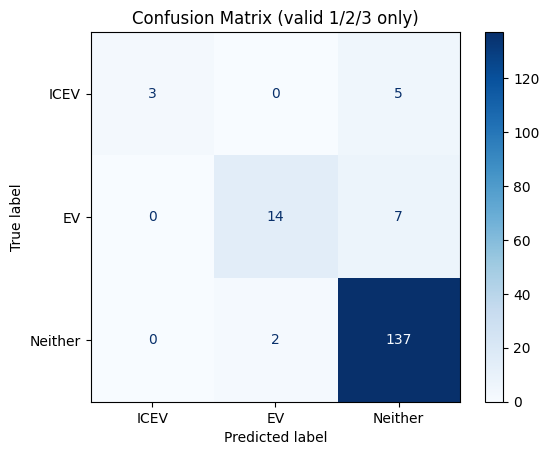

Accuracy: 0.9166666666666666
              precision    recall  f1-score   support

        ICEV     1.0000    0.3750    0.5455         8
          EV     0.8750    0.6667    0.7568        21
     Neither     0.9195    0.9856    0.9514       139

    accuracy                         0.9167       168
   macro avg     0.9315    0.6758    0.7512       168
weighted avg     0.9177    0.9167    0.9077       168



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# --- paths ---
pred_path = "infoevents2_with_predictions_20250930_175324.csv"
sol_path  = "infoevents2sol.xlsx"

# --- load ---
df_pred = pd.read_csv(pred_path)
sol_df  = pd.read_excel(sol_path)

# --- pick a join key ---
# normalized candidates in priority order
pred_keys = [c for c in ["deal_id", "sdcdealno", "investmentuuid"] if c in df_pred.columns]
sol_keys  = [c for c in ["deal_id", "sdcdealno", "investmentuuid"] if c in sol_df.columns]

join_key = None
for k in ["deal_id", "sdcdealno", "investmentuuid"]:
    if k in pred_keys and k in sol_keys:
        join_key = k
        break

if join_key is None:
    raise ValueError(
        "No common ID column found. "
        f"Pred cols: {', '.join(df_pred.columns)} | Sol cols: {', '.join(sol_df.columns)}"
    )

# unify to 'deal_id' internally
df_pred = df_pred.rename(columns={join_key: "deal_id"})
sol_df  = sol_df.rename(columns={join_key: "deal_id"})

# --- coerce prediction categories to numeric and keep only 1/2/3 ---
if "category" not in df_pred.columns:
    raise ValueError("Prediction file is missing 'category' column.")

df_pred["category_num"] = pd.to_numeric(df_pred["category"], errors="coerce")
df_pred_valid = df_pred[df_pred["category_num"].isin([1, 2, 3])].copy()

# --- diagnostics before merge ---
print("Join key:", "deal_id (from " + join_key + ")")
print("Pred rows:", len(df_pred), " | pred valid 1/2/3:", len(df_pred_valid))
print("Unique pred IDs:", df_pred["deal_id"].nunique(), " | valid IDs:", df_pred_valid["deal_id"].nunique())
print("Solution rows:", len(sol_df), " | unique sol IDs:", sol_df["deal_id"].nunique())
if len(df_pred_valid) == 0:
    print(" All predictions are NA/invalid (not in {1,2,3}). Nothing to evaluate.")

# --- merge on deal_id ---
if "categorysol" not in sol_df.columns:
    raise ValueError("Solutions file is missing 'categorysol' column.")

merged = pd.merge(
    df_pred_valid[["deal_id", "category_num"]],
    sol_df[["deal_id", "categorysol"]],
    on="deal_id",
    how="inner"
)

print("Merged rows:", len(merged))
if len(merged) == 0:
    pred_ids = set(df_pred_valid["deal_id"].astype(str))
    sol_ids  = set(sol_df["deal_id"].astype(str))
    inter    = pred_ids & sol_ids
    print("Overlap in IDs:", len(inter))
    print("Sample pred-only IDs:", list(pred_ids - sol_ids)[:5])
    print("Sample sol-only IDs:", list(sol_ids - pred_ids)[:5])

# --- evaluate ---
if len(merged) > 0:
    merged = merged[merged["categorysol"].isin([1, 2, 3])].copy()
    if len(merged) == 0:
        print("After filtering solution labels to {1,2,3}, no rows remain.")
    else:
        y_true = merged["categorysol"].astype(int).to_numpy()
        y_pred = merged["category_num"].astype(int).to_numpy()

        labels = [1, 2, 3]
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ICEV", "EV", "Neither"])
        disp.plot(cmap="Blues")
        plt.title("Confusion Matrix (valid 1/2/3 only)")
        plt.show()

        print("Accuracy:", accuracy_score(y_true, y_pred))
        print(classification_report(
            y_true, y_pred,
            labels=labels,
            target_names=["ICEV", "EV", "Neither"],
            digits=4,
            zero_division=0
        ))
else:
    print("No rows to evaluate. See diagnostics above.")

In [ ]:
import pandas as pd
import time
from datetime import datetime
from openai import OpenAI
from tqdm import tqdm
import re
import tiktoken

# --- Configuration ---
LITELLM_PROXY_URL = "https://litellmproxy.osu-ai.org/"
LITELLM_PROXY_API_KEY = "sk-S4vI4ayBQ6oPE-WSRBBn_g"

client = OpenAI(
    api_key=LITELLM_PROXY_API_KEY,
    base_url=LITELLM_PROXY_URL
)

OPENAI_MODEL = "GPT-4o"

# =====================================================================================================
# --- CONFIGURE FOR EACH NEW DATASET ---
# =====================================================================================================
# Change INPUT_FILE_NAME and the column mappings depending on the dataset.

# Example: For infoevents3.csv
INPUT_FILE_NAME = "infoevents3.csv"
ACTUAL_DESCRIPTION_COLUMN_IN_FILE = "applicationandtechnologytext"
ACTUAL_SYNOPSIS_COLUMN_IN_FILE = "dealsynopsistext"
ACTUAL_DATE_COLUMN_IN_FILE = None

# Example: For infoevents2.csv
# INPUT_FILE_NAME = "infoevents2.csv"
# ACTUAL_DESCRIPTION_COLUMN_IN_FILE = "descriptionshort"
# ACTUAL_SYNOPSIS_COLUMN_IN_FILE = None
# ACTUAL_DATE_COLUMN_IN_FILE = "funddate"

# =====================================================================================================

# --- Load Dataset ---
df = pd.read_csv(INPUT_FILE_NAME)

# Add result columns
df["category"] = ""
df["explanation"] = ""
df["confidence"] = ""
df["raw_output"] = ""

# Combine text fields
description_content = (
    df[ACTUAL_DESCRIPTION_COLUMN_IN_FILE].fillna("")
    if ACTUAL_DESCRIPTION_COLUMN_IN_FILE and ACTUAL_DESCRIPTION_COLUMN_IN_FILE in df.columns
    else ""
)
synopsis_content = (
    df[ACTUAL_SYNOPSIS_COLUMN_IN_FILE].fillna("")
    if ACTUAL_SYNOPSIS_COLUMN_IN_FILE and ACTUAL_SYNOPSIS_COLUMN_IN_FILE in df.columns
    else ""
)

df["combined_text"] = description_content + " " + synopsis_content

# Date handling
if ACTUAL_DATE_COLUMN_IN_FILE and ACTUAL_DATE_COLUMN_IN_FILE in df.columns:
    df["date_for_llm"] = pd.to_datetime(df[ACTUAL_DATE_COLUMN_IN_FILE], errors="coerce")
    df["deal_year"] = df["date_for_llm"].dt.year.fillna(df["date_for_llm"].dt.year.median())
else:
    print(f"⚠️ Date column '{ACTUAL_DATE_COLUMN_IN_FILE}' not found. Using default year.")
    df["deal_year"] = 2020

# --- Features ---
ev_keywords = [
    "electric", "battery", "lithium", "charging", "ev platform", "e-motor",
    "fuel cell", "hybrid electric", "plug-in hybrid", "bms",
    "battery management system", "inverter", "power electronics",
    "new energy vehicle", "electrification", "automobile batteries"
]
def has_ev_keywords(text):
    return any(re.search(r"\b" + keyword + r"\b", text, re.IGNORECASE) for keyword in ev_keywords)

propulsion_keywords = [
    "engine", "motor vehicle manufacturing", "powertrain", "drivetrain",
    "combustion", "diesel", "gasoline", "transmission", "ICEV", "automobiles",
    "trucks", "buses", "motorcycles", "vehicles", "internal combustion", "passenger cars"
]
accessory_service_keywords = [
    "dealership", "car rental", "logistics", "telematics", "electronic components",
    "software", "insurance", "real estate", "crm", "marketing", "fleet management"
]

def get_automotive_focus(text):
    text_lower = text.lower()
    is_propulsion = any(keyword in text_lower for keyword in propulsion_keywords)
    is_accessory_service = any(keyword in text_lower for keyword in accessory_service_keywords)
    if is_propulsion and not is_accessory_service:
        return "core propulsion or vehicle manufacturing"
    elif is_accessory_service and not is_propulsion:
        return "general automotive accessory or service (not core propulsion)"
    elif is_propulsion and is_accessory_service:
        return "mix of propulsion and accessory/service"
    else:
        return "general automotive or non-automotive"

df["has_ev_keywords"] = df["combined_text"].apply(has_ev_keywords)
df["automotive_focus"] = df["combined_text"].apply(get_automotive_focus)

# --- Category Definitions ---
CATEGORY_DEFINITIONS = {
    1: "ICEV Support: Deals related to ICE propulsion systems (engines, transmissions, combustion vehicles).",
    2: "EV Support: Deals related to EV propulsion systems (batteries, motors, charging, EV platforms).",
    3: "Neither: General automotive services/parts not directly tied to propulsion."
}

# --- Few-shot Examples (25 balanced) ---
example_block = """Example 1:
- Desc: Anhui Ankai Automobile Co Ltd manufactures and wholesales automobiles.
- Synop: JAC Group acquired a 28.12% stake.
EXPLANATION: This company manufactures automobiles without EV mention, making it ICEV Support.
CATEGORY: 1
CONFIDENCE: 95

Example 2:
- Desc: Manufacture motor vehicles
- Synop: Ford acquired Belgian motor vehicle manufacturer.
EXPLANATION: Direct manufacturing of combustion motor vehicles → ICEV Support.
CATEGORY: 1
CONFIDENCE: 95

Example 3:
- Desc: Cold-start injector systems for diesel engines
- Synop: OEM acquisition for combustion reliability in extreme weather.
EXPLANATION: Diesel engine injector systems directly support ICE propulsion.
CATEGORY: 1
CONFIDENCE: 95

Example 4:
- Desc: Parts logistics firm for ICE vehicle maintenance
- Synop: OEM acquired to streamline ICE supply chain.
EXPLANATION: Provides logistics services for ICE vehicles, supporting ICEV ecosystem.
CATEGORY: 1
CONFIDENCE: 95

Example 5:
- Desc: Data tool for ICE emission compliance
- Synop: Ensures combustion engine lines meet regulatory norms.
EXPLANATION: Regulatory compliance tools for ICE emissions → ICEV Support.
CATEGORY: 1
CONFIDENCE: 95

Example 6:
- Desc: Legacy ICE car manufacturer
- Synop: Acquisition to consolidate combustion vehicle production.
EXPLANATION: Legacy OEM focused on ICE production → ICEV Support.
CATEGORY: 1
CONFIDENCE: 95

Example 7:
- Desc: Lithium-ion battery supplier for EVs
- Synop: OEM secured supplier to support electrification.
EXPLANATION: Lithium-ion batteries are a core EV component → EV Support.
CATEGORY: 2
CONFIDENCE: 95

Example 8:
- Desc: EV chassis and frame producer
- Synop: Acquisition to scale lightweight EV platforms.
EXPLANATION: Supplies EV chassis/frames, critical for EV platforms.
CATEGORY: 2
CONFIDENCE: 95

Example 9:
- Desc: EV charging network API
- Synop: Used to manage station load balancing.
EXPLANATION: API for EV charging management → EV Support.
CATEGORY: 2
CONFIDENCE: 95

Example 10:
- Desc: Inverter and motor controller firm
- Synop: Powers electric powertrains in new vehicle line.
EXPLANATION: Inverters/controllers directly support EV propulsion.
CATEGORY: 2
CONFIDENCE: 95

Example 11:
- Desc: Battery module testing system
- Synop: Validates EV battery packs before installation.
EXPLANATION: Tests EV battery modules in assembly → EV Support.
CATEGORY: 2
CONFIDENCE: 95

Example 12:
- Desc: Smart grid energy optimizer
- Synop: Balances load during peak EV usage.
EXPLANATION: Optimizes grid load for EV charging → EV Support.
CATEGORY: 2
CONFIDENCE: 95

Example 13:
- Desc: EV fleet charging scheduler
- Synop: Coordinates charging for delivery vans.
EXPLANATION: Schedules EV fleet charging → EV Support.
CATEGORY: 2
CONFIDENCE: 95

Example 14:
- Desc: Retrofit kit provider
- Synop: OEM funds conversion of ICE fleets to EV.
EXPLANATION: Converts ICE fleets into EVs → EV Support.
CATEGORY: 2
CONFIDENCE: 95

Example 15:
- Desc: Electric utility vehicles
- Synop: Manufacturer acquired for electric tractors/trucks.
EXPLANATION: Explicit EV focus → EV Support.
CATEGORY: 2
CONFIDENCE: 95

Example 16:
- Desc: CRM platform for dealerships
- Synop: SaaS for sales analytics.
EXPLANATION: General dealership CRM not tied to propulsion → Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 17:
- Desc: Automotive ad-tech firm
- Synop: Helps OEMs run promotions.
EXPLANATION: Provides marketing solutions, unrelated to propulsion → Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 18:
- Desc: B2C car rental app
- Synop: Helps users compare and book cars.
EXPLANATION: Rental apps provide consumer services, not propulsion → Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 19:
- Desc: Logistics routing platform
- Synop: Focused on delivery optimization.
EXPLANATION: Provides logistics software, not propulsion → Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 20:
- Desc: Vehicle pricing insights API
- Synop: SaaS tool for dealerships.
EXPLANATION: Pricing insights not related to propulsion → Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 21:
- Desc: Electric utility company
- Synop: Acquisition of regional power provider.
EXPLANATION: Utility company, not vehicle propulsion → Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 22:
- Desc: Supplier of car seats and interiors
- Synop: OEM acquisition for interior design.
EXPLANATION: Interior parts unrelated to propulsion → Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 23:
- Desc: Service partner for general electronics
- Synop: OEM partners for non-propulsion electronics.
EXPLANATION: General electronics not tied to ICE/EV propulsion → Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 24:
- Desc: EV AI degradation prediction
- Synop: Predicts EV battery health.
EXPLANATION: EV-specific AI tool → EV Support.
CATEGORY: 2
CONFIDENCE: 95

Example 25:
- Desc: Smart charger app
- Synop: Manages home/fleet charging.
EXPLANATION: EV charger scheduling → EV Support.
CATEGORY: 2
CONFIDENCE: 95
"""

# --- Classification Function ---
def get_openai_classification(text_description, deal_synopsis, deal_year, has_ev_keywords_flag, automotive_focus_type, row_sdcdealno=None):
    system_message_content = (
        "You are an expert automotive investment consultant. "
        "Classify each deal as: 1 (ICEV Support), 2 (EV Support), or 3 (Neither).\n\n"
    )
    for cat_num, desc in CATEGORY_DEFINITIONS.items():
        system_message_content += f"Category {cat_num}: {desc}\n"
    system_message_content += "\nHere are diverse examples:\n\n"
    system_message_content += example_block + "\n--- End Examples ---\n\n"

    user_message_content = (
        f"Now classify this deal:\n"
        f"Description: '''{text_description}'''\n"
        f"Deal Synopsis: '''{deal_synopsis}'''\n"
        f"Date Announced: {int(deal_year)}\n"
        f"Analyzed features: EV Keywords: {'Yes' if has_ev_keywords_flag else 'No'}, Focus: {automotive_focus_type}\n\n"
        f"EXPLANATION:\nCATEGORY: [1/2/3/NA]\nCONFIDENCE: [1-100]\n"
    )

    try:
        response = client.chat.completions.create(
            model=OPENAI_MODEL,
            messages=[{"role": "system", "content": system_message_content}, {"role": "user", "content": user_message_content}],
            temperature=0,
            max_tokens=200
        )
        content = response.choices[0].message.content.strip() if response.choices else ""
        parsed_category, parsed_confidence, parsed_explanation = "NA", 0, ""
        if content:
            lines = content.splitlines()
            current_section = None
            for line in lines:
                line = line.strip()
                if line.upper().startswith("EXPLANATION:"):
                    current_section = "EXPLANATION"
                    parsed_explanation += line[len("EXPLANATION:"):].strip() + " "
                elif line.upper().startswith("CATEGORY:"):
                    value = line[len("CATEGORY:"):].strip()
                    if value.isdigit() and int(value) in {1, 2, 3}:
                        parsed_category = int(value)
                    elif value.upper() == "NA":
                        parsed_category = "NA"
                elif line.upper().startswith("CONFIDENCE:"):
                    value = line[len("CONFIDENCE:"):].strip()
                    if value.isdigit():
                        parsed_confidence = int(value)
                elif current_section == "EXPLANATION":
                    parsed_explanation += line + " "
            parsed_explanation = parsed_explanation.strip()
        return {"category": parsed_category, "confidence": parsed_confidence, "explanation": parsed_explanation, "raw_output": content}
    except Exception as e:
        return {"category": "error", "confidence": 0, "explanation": str(e), "raw_output": f"API Error: {e}"}

# --- Tokenizer Setup ---
try:
    enc = tiktoken.get_encoding("o200k_base") if OPENAI_MODEL.lower() in {"gpt-4o", "gpt-4o-mini"} else tiktoken.get_encoding("cl100k_base")
except KeyError:
    enc = tiktoken.get_encoding("cl100k_base")

# --- Main Loop ---
df["tokens_used"] = 0
for i, row in tqdm(df.iterrows(), total=len(df)):
    desc_val = row[ACTUAL_DESCRIPTION_COLUMN_IN_FILE] if ACTUAL_DESCRIPTION_COLUMN_IN_FILE in df.columns else ""
    syn_val = row[ACTUAL_SYNOPSIS_COLUMN_IN_FILE] if ACTUAL_SYNOPSIS_COLUMN_IN_FILE in df.columns else ""
    year_val = row["deal_year"]

    result = get_openai_classification(
        text_description=str(desc_val),
        deal_synopsis=str(syn_val),
        deal_year=year_val,
        has_ev_keywords_flag=row["has_ev_keywords"],
        automotive_focus_type=row["automotive_focus"],
        row_sdcdealno=row.get("sdcdealno", "N/A")
    )

    df.at[i, "category"] = result["category"]
    df.at[i, "confidence"] = result["confidence"]
    df.at[i, "explanation"] = result["explanation"]
    df.at[i, "raw_output"] = result["raw_output"]

    df.at[i, "tokens_used"] = len(enc.encode(str(desc_val) + " " + str(syn_val)))
    time.sleep(1.2)

# --- Save Results ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"{INPUT_FILE_NAME.replace('.csv','')}_with_predictions_{timestamp}.csv"
df.to_csv(filename, index=False)
print(f"✅ Saved predictions to {filename}")



⚠️ Date column 'None' not found. Using default year.


100%|██████████| 5172/5172 [3:52:59<00:00,  2.70s/it]

✅ Saved predictions to infoevents3_with_predictions_20250930_215033.csv


Join key -> 'deal_id' (from 'sdcdealno')
Pred rows: 5172  | pred valid 1/2/3: 2415
Unique pred IDs: 2651  | valid IDs: 1514
Solution rows: 266  | unique sol IDs: 266
Merged rows: 250


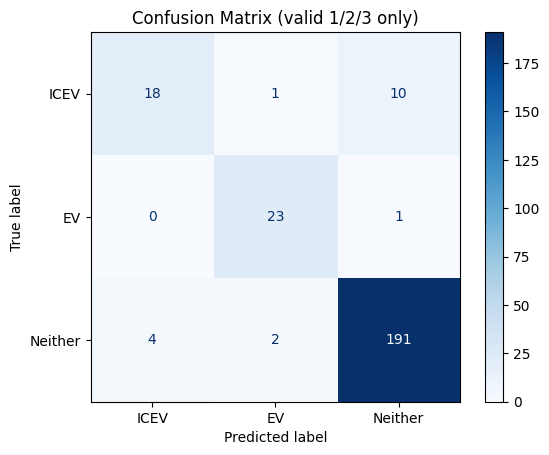

Accuracy: 0.928
              precision    recall  f1-score   support

        ICEV     0.8182    0.6207    0.7059        29
          EV     0.8846    0.9583    0.9200        24
     Neither     0.9455    0.9695    0.9574       197

    accuracy                         0.9280       250
   macro avg     0.8828    0.8495    0.8611       250
weighted avg     0.9249    0.9280    0.9246       250



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# --- paths (update if you rename/move files) ---
pred_path = "infoevents3_with_predictions_20250930_215033.csv"
sol_path  = "infoevents3sol.xlsx"

# --- load ---
df_pred = pd.read_csv(pred_path)
sol_df  = pd.read_excel(sol_path)

# --- choose join key (priority: sdcdealno -> deal_id -> investmentuuid) ---
pred_keys = [c for c in ["sdcdealno", "deal_id", "investmentuuid"] if c in df_pred.columns]
sol_keys  = [c for c in ["sdcdealno", "deal_id", "investmentuuid"] if c in sol_df.columns]

join_key = None
for k in ["sdcdealno", "deal_id", "investmentuuid"]:
    if k in pred_keys and k in sol_keys:
        join_key = k
        break

if join_key is None:
    raise ValueError(
        "No common ID column found to join on. "
        f"Pred cols: {', '.join(df_pred.columns)} | Sol cols: {', '.join(sol_df.columns)}"
    )

# normalize to common 'deal_id'
df_pred = df_pred.rename(columns={join_key: "deal_id"})
sol_df  = sol_df.rename(columns={join_key: "deal_id"})

# --- sanity checks for required columns ---
if "category" not in df_pred.columns:
    raise ValueError("Prediction file is missing a 'category' column.")

# Solutions label column name (commonly 'categorysol')
sol_label_col = "categorysol" if "categorysol" in sol_df.columns else None
if sol_label_col is None:
    # try a couple fallbacks often seen in these sheets
    for alt in ["category_sol", "label", "true_label"]:
        if alt in sol_df.columns:
            sol_label_col = alt
            break
if sol_label_col is None:
    raise ValueError(f"Solutions file missing label column (expected 'categorysol'). Columns: {', '.join(sol_df.columns)}")

# --- coerce prediction categories to numeric and keep only 1/2/3 ---
df_pred["category_num"] = pd.to_numeric(df_pred["category"], errors="coerce")
df_pred_valid = df_pred[df_pred["category_num"].isin([1, 2, 3])].copy()

# --- diagnostics before merge ---
print(f"Join key -> 'deal_id' (from '{join_key}')")
print("Pred rows:", len(df_pred), " | pred valid 1/2/3:", len(df_pred_valid))
print("Unique pred IDs:", df_pred["deal_id"].nunique(), " | valid IDs:", df_pred_valid["deal_id"].nunique())
print("Solution rows:", len(sol_df), " | unique sol IDs:", sol_df["deal_id"].nunique())
if len(df_pred_valid) == 0:
    print("All predictions are NA/invalid (not in {1,2,3}). Nothing to evaluate.")

# --- merge on deal_id ---
merged = pd.merge(
    df_pred_valid[["deal_id", "category_num"]],
    sol_df[["deal_id", sol_label_col]],
    on="deal_id",
    how="inner"
)

print("Merged rows:", len(merged))
if len(merged) == 0:
    pred_ids = set(df_pred_valid["deal_id"].astype(str))
    sol_ids  = set(sol_df["deal_id"].astype(str))
    inter    = pred_ids & sol_ids
    print("Overlap in IDs:", len(inter))
    print("Sample pred-only IDs:", list(pred_ids - sol_ids)[:5])
    print("Sample sol-only IDs:", list(sol_ids - pred_ids)[:5])

# --- evaluate ---
if len(merged) > 0:
    # keep only solution labels 1/2/3
    merged = merged[merged[sol_label_col].isin([1, 2, 3])].copy()
    if len(merged) == 0:
        print("After filtering solution labels to {1,2,3}, no rows remain.")
    else:
        y_true = merged[sol_label_col].astype(int).to_numpy()
        y_pred = merged["category_num"].astype(int).to_numpy()

        labels = [1, 2, 3]
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ICEV", "EV", "Neither"])
        disp.plot(cmap="Blues")
        plt.title("Confusion Matrix (valid 1/2/3 only)")
        plt.show()

        print("Accuracy:", accuracy_score(y_true, y_pred))
        print(classification_report(
            y_true, y_pred,
            labels=labels,
            target_names=["ICEV", "EV", "Neither"],
            digits=4,
            zero_division=0
        ))
else:
    print("No rows to evaluate. See diagnostics above.")